In [0]:
!pip install tsfresh
!pip install tqdm

    100% |████████████████████████████████| 1.2MB 6.3MB/s 


In [0]:
# The essentials
import pandas as pd
import numpy as np

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Progress bars
from tqdm import tqdm

# Access our Google Drive
from google.colab import drive

# Gradient Boosting
from catboost import CatBoostRegressor

from collections import defaultdict

In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_values.csv', index_col=0, parse_dates=['timestamp'])
test_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_values.csv', index_col=0, parse_dates=['timestamp'])
label_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_labels.csv', index_col='process_id')

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
PROCESS_COMBINATION = 15

train_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_features_{}.csv'.format(PROCESS_COMBINATION), index_col='process_id')
filtered_train_df = train_df[(train_df['process_id'].isin(train_features.index))]
final_phase_filtered_train_df = filtered_train_df[(filtered_train_df['phase'] == 'final_rinse') & (filtered_train_df['target_time_period'])]

In [0]:
all_labels = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_labels.csv', index_col=['process_id'])

y_first_part = all_labels.loc[train_features.index].copy()
y_second_part = all_labels.loc[train_features.index].copy()
for process in train_features.index:
  process_data = final_phase_filtered_train_df[final_phase_filtered_train_df['process_id'] == process]
  
  process_data = process_data.sort_values(by='timestamp')
  process_data['index'] = list(range(len(process_data)))
  process_data['group_index'] = process_data['index'] // (len(process_data) / 2)
  
  process_data['return_flow'] = process_data['return_flow'].apply(lambda x: max(0, x))
  
  process_data['label'] = process_data['return_turbidity'] * process_data['return_flow'] * process_data['target_time_period']
  
  y_vals = process_data.groupby('group_index')['label'].sum().values
  
  y_first_part.loc[process, 'final_rinse_total_turbidity_liter'] = max(0, y_vals[0])
  y_second_part.loc[process, 'final_rinse_total_turbidity_liter'] = max(0, y_vals[1])

In [0]:
import os
from sklearn.decomposition import PCA

for process_comb in [3]:
    test_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_features_{}.csv'.format(process_comb), index_col=['process_id'])
    val_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/val_features_adv_{}.csv'.format(process_comb), index_col=['process_id'])
    train_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_features_adv_{}.csv'.format(process_comb), index_col=['process_id'])

    all_labels = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_labels.csv', index_col=['process_id'])
    labels = pd.concat([all_labels.loc[train_features.index], all_labels.loc[val_features.index]])
    
    all_features = pd.concat([train_features, val_features, test_features])
    
    null_columns = test_features.columns[test_features.isnull().sum() > 0]
    for col in set(train_features.columns) - set(test_features.columns):
        train_features = train_features.drop(col, axis=1)
        val_features = val_features.drop(col, axis=1)
    train_features = train_features.drop(null_columns, axis=1)
    val_features = val_features.drop(null_columns, axis=1)
    test_features = test_features.drop(null_columns, axis=1)
        
    #test_features = test_features.drop(['label', 'pipeline_L12'], axis=1)    

    pca = PCA()
    embeddings = pca.fit_transform(pd.concat([train_features, val_features, test_features], axis=0))

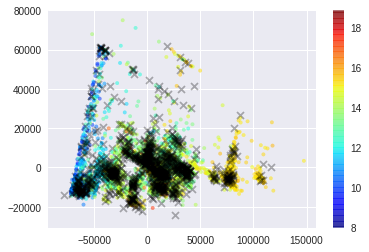

In [57]:
vis_x = embeddings[:, 0][:(len(train_features)+len(val_features))]
vis_y = embeddings[:, 1][:(len(train_features)+len(val_features))]
plt.scatter(vis_x, vis_y, c=list(np.log(labels['final_rinse_total_turbidity_liter'].values)), cmap=plt.cm.get_cmap("jet"), marker='.', alpha=0.5)
plt.colorbar()

vis_x = embeddings[:, 0][(len(train_features)+len(val_features)):]
vis_y = embeddings[:, 1][(len(train_features)+len(val_features)):]
plt.scatter(vis_x, vis_y, c='k', marker='x', alpha=0.3)
plt.show()

In [1]:
pca.__dict__

NameError: ignored

In [48]:
def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 290000))

class MAPEMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, targets, weight):
        return custom_mape(np.exp(approxes), np.exp(targets)), len(targets)

X_train = embeddings[:len(train_features), :]
X_val = embeddings[len(train_features):(len(train_features)+len(val_features)), :]

y_train = np.log(all_labels.loc[train_features.index])
y_val = np.log(all_labels.loc[val_features.index])

cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, learning_rate=0.33,
                        loss_function='MAPE', eval_metric=MAPEMetric())
cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50)

0:	learn: 0.8490310	test: 0.8194781	best: 0.8194781 (0)	total: 58.1ms	remaining: 1h 36m 54s
50:	learn: 0.8490262	test: 0.8194729	best: 0.8194729 (50)	total: 420ms	remaining: 13m 43s
100:	learn: 0.8490081	test: 0.8194532	best: 0.8194532 (100)	total: 683ms	remaining: 11m 15s
150:	learn: 0.8489403	test: 0.8193776	best: 0.8193776 (150)	total: 948ms	remaining: 10m 26s
200:	learn: 0.8486835	test: 0.8190858	best: 0.8190858 (200)	total: 1.2s	remaining: 9m 57s
250:	learn: 0.8477001	test: 0.8179497	best: 0.8179497 (250)	total: 1.47s	remaining: 9m 45s
300:	learn: 0.8439086	test: 0.8134976	best: 0.8134976 (300)	total: 1.73s	remaining: 9m 33s
350:	learn: 0.8295231	test: 0.7968705	best: 0.7968705 (350)	total: 2s	remaining: 9m 27s
400:	learn: 0.7964854	test: 0.7629626	best: 0.7629626 (400)	total: 2.38s	remaining: 9m 52s
450:	learn: 0.7440985	test: 0.7132336	best: 0.7132336 (450)	total: 2.81s	remaining: 10m 20s
500:	learn: 0.6160639	test: 0.6107726	best: 0.6107726 (500)	total: 3.22s	remaining: 10m 38s

In [43]:
pd.concat([train_features, val_features, test_features],axis=0).columns[pd.concat([train_features, val_features, test_features], axis=0).isnull().sum()]

Index(['pipeline_L1', 'pipeline_L1', 'pipeline_L1', 'pipeline_L1',
       'pipeline_L1', 'pipeline_L1', 'pipeline_L1', 'pipeline_L1',
       'pipeline_L1', 'pipeline_L1',
       ...
       'pipeline_L1', 'pipeline_L1', 'pipeline_L1', 'pipeline_L1',
       'pipeline_L1', 'pipeline_L1', 'pipeline_L1', 'pipeline_L1',
       'pipeline_L1', 'pipeline_L1'],
      dtype='object', length=254)

In [0]:
sum(pd.concat([train_features, val_features, test_features], axis=0).isnull().sum() > 0)

2